# Домашнее задание №3 (ИАД-16)
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv("bikes_rent.csv", sep=",")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12 (соответственно январь---декабрь)
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6 (соответственно понедельник---воскресенье)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _workthersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. Давайте посмотрим на графиках, как целевой признак зависит от остальных

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


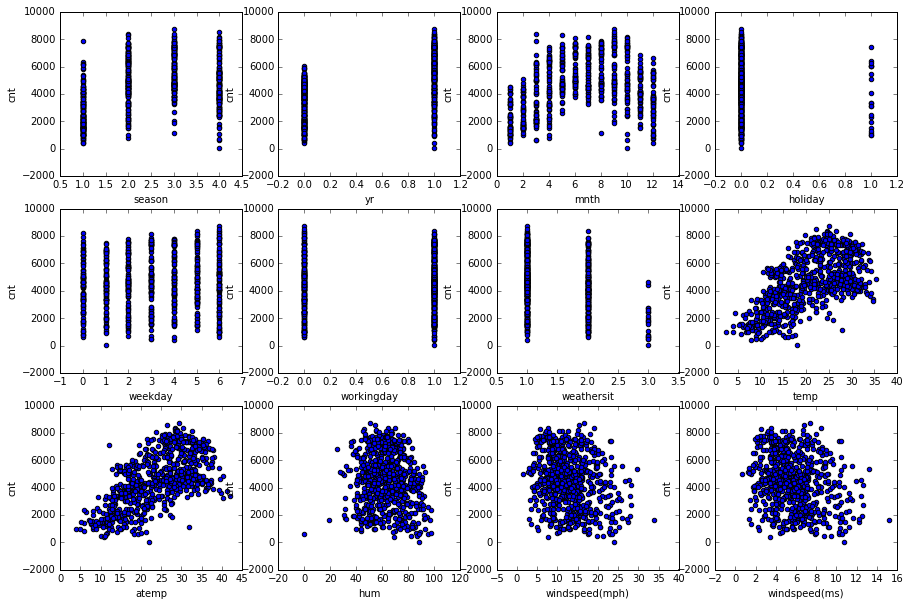

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.25 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: в зимние месяцы кол-во велосипедов сданных в аренду не так велико как в другие времена года. Больше всего велосипедов сдается в сентябре.
1. В какие дни: рабочие или выходные, людям чаще нужен велосипед?
   * ответ: в выходные люди арендуют велосипеды немного чаще
1. Укажите одну переменную, которая не влияет на cnt.
   * ответ: workingday (рабочий или нерабочий день)
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: holiday

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [24]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
mask1 = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
         'atemp', 'hum', 'windspeed(mph)','windspeed(ms)']
df_corr = df[mask1].corrwith(df['cnt'], axis=0)
df_corr

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [5]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
mask2 = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
df[mask2].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли единиц у бинарных признаков.

In [6]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
print(df.mean())

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Попробуем обучить самую простую линейную регрессию
А именно, построим зависимость cnt от atemp

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
# Код 1.4 (1 балл)
# Создайте объект линейного регрессора, обучите его на X = df["atemp"] и y = df["cnt]
# Затем сделайте предсказание на X_test = linspace (переменная, объявленная ниже) и запишите в переменную y_test
linspace = np.linspace(0, 40, 1000)[:, np.newaxis]
lr = LinearRegression()
X_train = df['atemp'].reshape(-1,1)
Y_train = df['cnt']
lr.fit(X_train,  Y_train)
y_test = lr.predict(linspace)

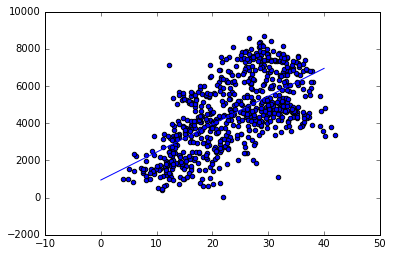

In [9]:
plt.scatter(df["atemp"], df["cnt"])
plt.plot(linspace.ravel(), y_test)

У вас должна получиться прямая, проходящая через изображенные точки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на дисперсию. Это можно сделать с помощью метода scale:

In [10]:
from sklearn.preprocessing import scale

In [11]:
X = scale(df[df.columns[:-1]])
y = df["cnt"]

Давайте обучим линейную регрессию на полных данных и посмотрим на веса признаков.

In [12]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lr2 = LinearRegression()
lr2.fit(X,y)
for i, j, in zip(df.columns, lr2.coef_):
    print  ("{:14}: {:>5}".format(i, j))

season        : 570.8689333889174
yr            : 1021.964901049683
mnth          : -141.30507817619798
holiday       : -86.75486239906427
weekday       : 137.22641374692773
workingday    : 56.392494746369806
weathersit    : -330.2263474661352
temp          : 367.4755167674707
atemp         : 585.5561570062912
hum           : -145.61289934218058
windspeed(mph): 12457527808879.979
windspeed(ms) : -12457527809078.432


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу $||Xw-y||$ прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором — Ridge.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [13]:
from sklearn.linear_model import Ridge, Lasso

In [14]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
lr_Lasso = Lasso()
lr_Lasso.fit(X,y)
for i, j, in zip(df.columns, lr_Lasso.coef_):
    print  ("{0}: {1}".format(i, j))

season: 560.2416160308866
yr: 1019.4634940657196
mnth: -128.73062703678733
holiday: -86.15278133371095
weekday: 137.34789390496329
workingday: 55.21237064135665
weathersit: -332.36985696234865
temp: 376.3632362096965
atemp: 576.5307935045531
hum: -144.12915500348586
windspeed(mph): -197.1396894024949
windspeed(ms): -2.8040600045891187e-08


In [15]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
lr_Ridge = Ridge()
lr_Ridge.fit(X,y)
for i, j in zip(df.columns, lr_Ridge.coef_):
    print  ("{0}: {1}".format(i, j))

season: 563.0645722520115
yr: 1018.9483787875286
mnth: -131.87332028246982
holiday: -86.74609799709252
weekday: 138.00511117871898
workingday: 55.903110375065005
weathersit: -332.34978849907475
temp: 386.45788919192546
atemp: 566.3470470600495
hum: -145.0713272986718
windspeed(mph): -99.25944108209039
windspeed(ms): -99.25944115404246


__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл)__: Регуляризация вводится для уменьшения значимости признаков с большими весами, потому как не решив эту проблему модель может переучиться. Принцип работы L1 регуляризации состоит в том, что модель штрафует большие веса прибавляя к ним их абсолютных значений к функции ошибок, а при использовании L2 регуляризации прибавляется сумма их квадратов. После этого в модели не так велико влияние факторов с большими весами, а так же начинает учитывать признаки, которые изначально имели слишком малый вес.

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение последнему факту было дано на лекции (всё из-за ромбообразных линий уровня L1-нормы).

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$. 

In [16]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso,
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i in range(len(alphas)):
    lr_Lasso = Lasso(alpha=alphas[i])
    lr_Ridge = Ridge(alpha=alphas[i])
    lr_Lasso.fit(X,y)
    lr_Ridge.fit(X,y)
    coefs_lasso[i] = lr_Lasso.coef_
    coefs_ridge[i] = lr_Ridge.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

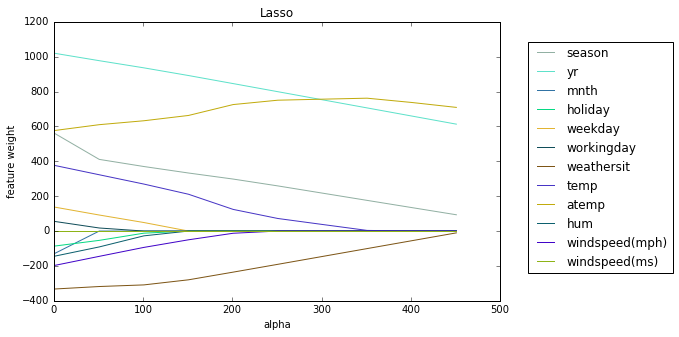

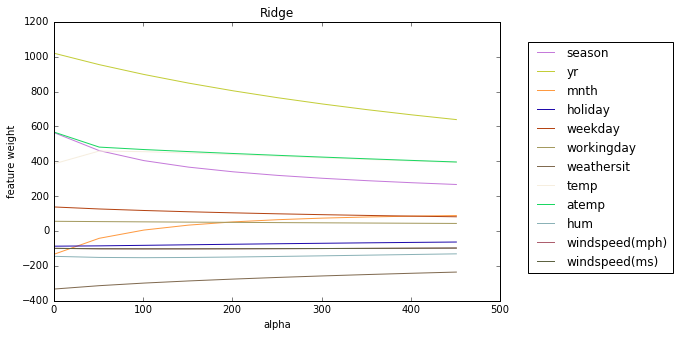

In [18]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

__Блок 3. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регрессор (Ridge или Lasso) агрессивнее уменьшает веса?
    * Ответ: из графика видно, что регрессор Lasso уменьшает веса гораздо агрессивнее
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Многие веса станут нулевыми и эти факторы перестанут оказывать влияние на предсказание.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha? А Ridge?
    * Ответ: Да, можно. Lasso при низком alpha ставит очень маленький вес для одного из признаков windspeed, а при увеличении alpha этому признаку ставится вовсе нулевой вес.
    Ridge не исключает признаки ни при каких альфа.
1. Какой из регрессоров подойдет для отбора неинформативных признаков?
    * Ответ: регресор Lasso подходит для этого, так как мы уже заметили, что он обнуляет веса неинформативных признаков

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого в scikit-learn есть специальный класс __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) × k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [19]:
from sklearn.linear_model import LassoCV

Alpha = 26
	season: 431.5050146339466
	yr: 997.5949579859101
	mnth: -0.0
	holiday: -71.47585346746403
	weekday: 113.41239026287387
	workingday: 36.831355314954706
	weathersit: -323.6791084216387
	temp: 348.31239784094146
	atemp: 599.3914909821123
	hum: -122.4173971630275
	windspeed(mph): -170.44942053622734
	windspeed(ms): -2.2574539376593483e-08


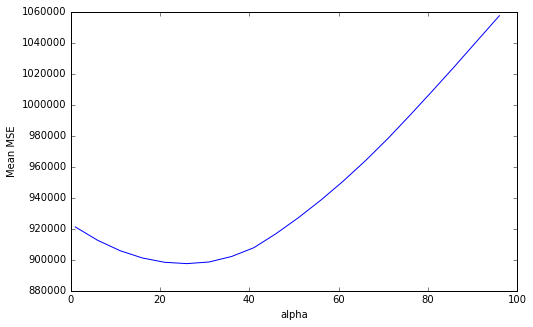

In [20]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
model = LassoCV(alphas=alphas, cv=3)
model.fit(X,y)
plt.figure(figsize=(8, 5))
plt.plot(model.alphas_, model.mse_path_.mean(axis=1))
plt.xlabel("alpha")
plt.ylabel("Mean MSE")

print("Alpha = {0}".format(model.alpha_))
for feature, coef in zip(df.columns, model.coef_):
    print  ("\t{0}: {1}".format(feature, coef))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Alpha = 96; MSE = 725129.9885949264
Alpha = 91; MSE = 625492.4295993953
Alpha = 86; MSE = 1232891.0432576775


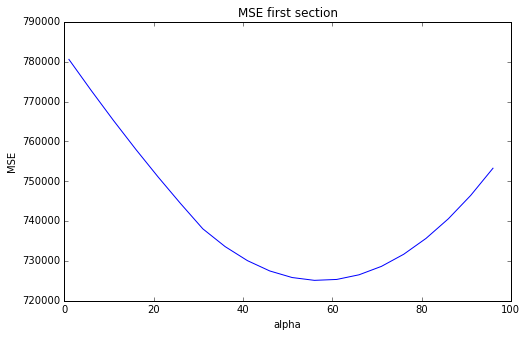

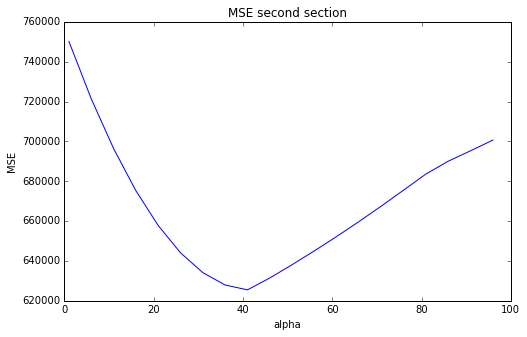

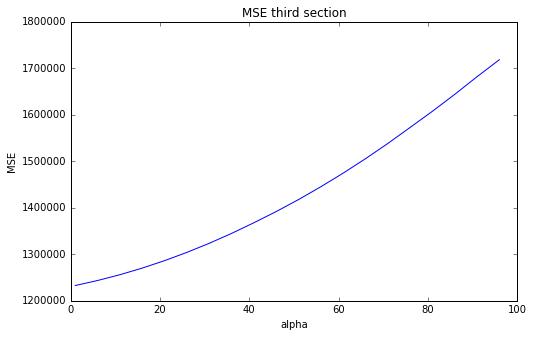

In [22]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
for  alph, mse in zip(model.alphas_ ,model.mse_path_.min(axis=0)):
    print ("Alpha = {0}; MSE = {1}".format(alph, mse))

plt.figure(figsize=(8, 5))
plt.plot(model.alphas_, model.mse_path_[:,0])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE first section")

plt.figure(figsize=(8, 5))
plt.plot(model.alphas_, model.mse_path_[:,1])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE second section")

plt.figure(figsize=(8, 5))
plt.plot(model.alphas_, model.mse_path_[:,2])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE third section")

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 4. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами, посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: Выбранные признаки: yr, atemp, season, weekday. Если говорить о годе (переменной yr), то хоть и по графику видна возрастающая линейная зависимость, но утверждать, что в следующем году велосипеды станут еще популярней мы не можем, потому что может быть будет изобретен новый вид транспорта или просто сменится мода на что-то другое. И тогда даже при неизменности остальных признаков, кол-во велосипедов может упасть.
    Возрастающая линейная зависимость также видна и с переменной atemp, можно сказать и что чем выше значение этого признака, тем больше людей захотят взять велосипеды, однако только в определенном промежутке [0; 35], так как после значения в 35, показатель взятых велосипедов начинает падать.
    Для переменных season и weekday так же видна возрастающая линейная зависимость. И мы можем ужтверждать что чем больше их значение тем выше будут показатель взятых велосипедов.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами, посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: weathersit, windspeed(mph), hum для всех трех признаков отчетливо видна убывающая линейная зависимость. Мы можем утверждать, что чем больше величина этих признаков, тем меньше людей возьмут велоспипеды.
1. Выберите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Регрессор обнулил коэффициент только при mnth, по сути этот признак совпадает с признаком season, по этому регрессор выставил большой вес у одного признака и нулевой у второго.

Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.